# Imports

In [55]:
# standard
    # arrays & train
import pandas as pd
import numpy as np
    # stats
from scipy import stats
    # access
import os
import requests
    # random
import random

# vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
    # regex
import re
import unicodedata
import nltk
    # tokenizer
from nltk.tokenize.toktok import ToktokTokenizer
    # stopwords
from nltk.corpus import stopwords
    # web scraper
from bs4 import BeautifulSoup
    # ?
from wordcloud import WordCloud

# modeling
    # sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfitrainVectorizer
from sklearn.tree import DecisionTreeClassifier
# scripts
import wrangle as w
import env


## Acquire

In [2]:
train = w.process_all_repos()

## Prepare

##### Prepare Steps:
- Lowercase All Text
- Remove accented characters and non-ASCII characters
- Remove special characters
- Tokenize
- Lemmatize
- Remove Stopwords
- Add extra Stopwords

### Extra stopword manipulation

In [4]:
extra_stop_words = pd.read_csv('extra_stop_words.csv')
extra_stop_words = extra_stop_words['0'].to_list()

In [5]:
train = w.transform_data(train, extra_stopwords=extra_stop_words)

### Split

In [56]:
train, test = train_test_split(train, train_size=.8, random_state=666)

In [6]:
# getting all words joined for each language
py_words = ' '.join(train[train.language == 'Python'].lematized)
c_words = ' '.join(train[train.language == 'C++'].lematized)
mark_words = ' '.join(train[train.language == 'Markdown'].lematized)
all_words = ' '.join(train.lematized)

In [7]:
# Get word counts for each language
py_counts =pd.Series(py_words.split()).value_counts()
c_counts =pd.Series(c_words.split()).value_counts()
mark_counts =pd.Series(mark_words.split()).value_counts()
all_counts =pd.Series(all_words.split()).value_counts()

In [8]:
#Combine the value counts into one dataframe
word_counts = pd.concat([py_counts, c_counts, mark_counts, all_counts], axis=1)
word_counts.columns = ['py_counts', 'c_counts', 'mark_counts', 'all_counts']

# Fill the nulls with 0
word_counts.fillna(0, inplace=True)
#Recast all columns as integers
word_counts = word_counts.astype('int')

#take a look
word_counts.head()

,py_counts,c_counts,mark_counts,all_counts
model,5455,138,48,5856
python,3154,109,6,3409
data,3092,101,144,3524
training,2523,74,19,2700
file,2436,116,117,2906


In [50]:
# this is how we will reduce some junk words that are not any language
additional_stop_words = word_counts[word_counts.all_counts == 1].index.tolist()
# pd.Series(additional_stop_words).to_csv('extra_stop_words.csv')

## Explore

In [10]:
# List lema will be lematized words in list format
c = []
for i, val in enumerate(train.lematized):
     c.append(val.split())
train['list_lema'] = c

In [11]:
train['len_lematized'] = train['lematized'].str.len()

Checking distributions of Python:


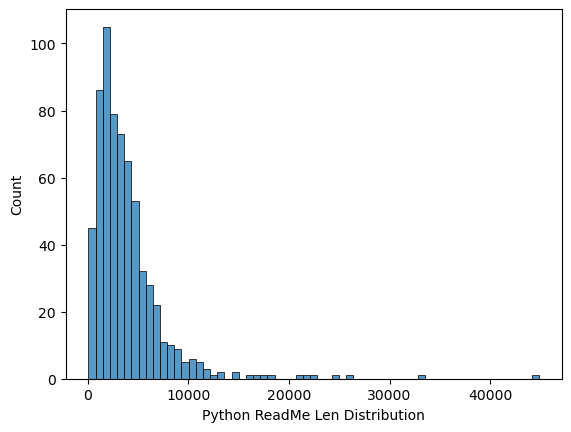

+ + + + + + + + + + + + + + + +
Checking distributions of C++:


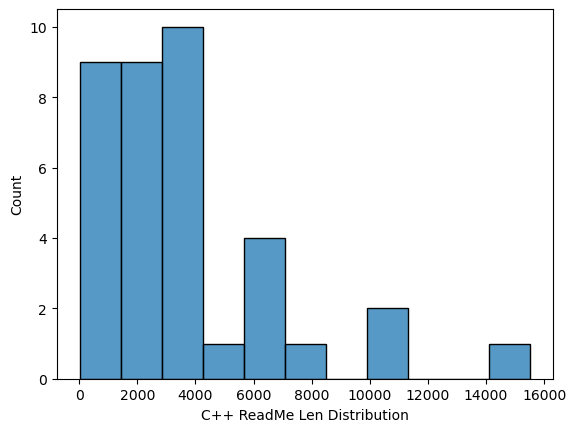

+ + + + + + + + + + + + + + + +
Checking distributions of Other:


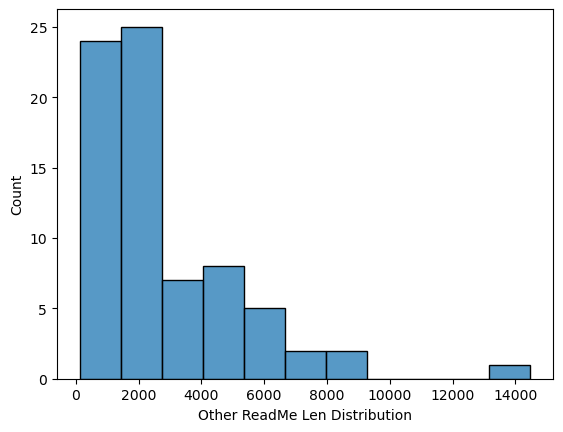

+ + + + + + + + + + + + + + + +
Checking distributions of Markdown:


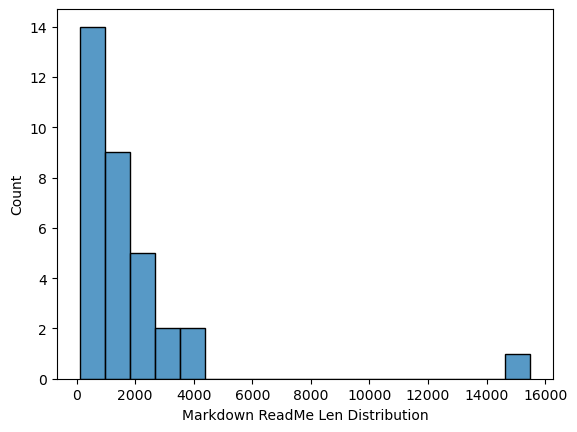

+ + + + + + + + + + + + + + + +
Checking distributions of All:


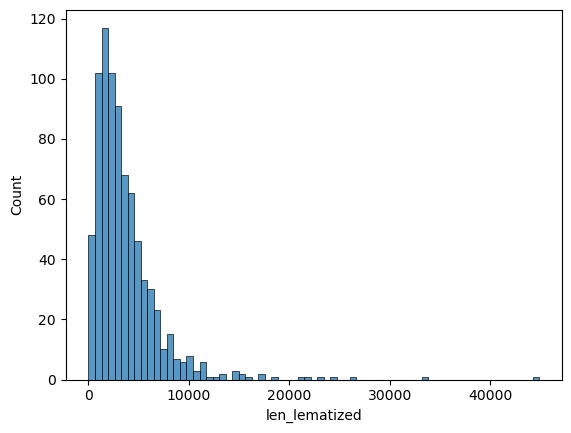

+ + + + + + + + + + + + + + + +


In [12]:
# Checking readme word len distributions
w.language_distributions(train)

## The distributions of word count in all languages is *inverse gausian-like*, the variations is in volume of readmes

In [13]:
all_counts

model       5856
data        3524
python      3409
file        2906
training    2700
            ... 
maskfeat       2
19148          2
0472873        2
00206          2
dechow         2
Name: count, Length: 20389, dtype: int64

In [14]:
# What are the most frequent py words?
py_counts.head()

model       5455
python      3154
data        3092
training    2523
file        2436
Name: count, dtype: int64

In [15]:
# What are the most frequent c words?
c_counts.head()

install    146
build      141
model      138
example    138
1          121
Name: count, dtype: int64

In [49]:
# What are the most frequent Markdown words?
mark_counts.head()

data           144
dataset        122
file           117
contains        83
participant     74
Name: count, dtype: int64

<div class="alert alert-block alert-info"> 
<b>Takeaway:</b>
    
- Words like 
- Words like 
</div>

In [17]:
# Get word frequencies for each language
py_freq =pd.Series(py_words.split()).value_counts(normalize=True)* 100
c_freq = pd.Series(c_words.split()).value_counts(normalize=True)* 100
mark_freq = pd.Series(mark_words.split()).value_counts(normalize=True)* 100
all_freq = pd.Series(all_words.split()).value_counts(normalize=True)* 100

In [18]:
#Combine the value counts into one dataframe
word_freq = pd.concat([py_freq, c_freq, mark_freq, all_freq], axis=1)
word_freq.columns = ['py_freq', 'c_freq', 'mark_freq', 'all_freq']

# Fill the nulls with 0
word_freq.fillna(0, inplace=True)

#take a look
word_freq.head()

,py_freq,c_freq,mark_freq,all_freq
model,1.540299,0.709475,0.568115,1.425112
python,0.890578,0.560382,0.071014,0.829612
data,0.873071,0.519254,1.704344,0.857598
training,0.712406,0.380443,0.224879,0.657070
file,0.687840,0.596370,1.384779,0.707202


# Explore Questions:
#### Looking at **most** frequent word of Python:

### 1. Is `'model'` statistically significant to Python compared to *All* other languages
- $H_0$: There is no relationship between model and Python
- $H_a$: There is a relationship between model and Python

#### Steps:
- 1a. Engineer column that counts `'model'` within every value
- 1b. Compare that by language


In [19]:
# engineer column that counts 'model' within every value
    # chi2
train['has_model'] = train.lematized.str.contains('model').astype(int)
has_model_python = train.has_model[train['language'] == 'Python']
    # mann-whitney
train['model_count'] = train.lematized.str.count('model')
model_python = train.model_count[train['language'] == 'Python']
model_other = train.model_count[train['language'] != 'Python']

In [20]:
# running a chi2 test based on whether or not the str contains model or not
w.chi2_test(has_model_python,train['has_model'],contingency=True)

We can reject the null hypothesis with a p-score of: {1.6306665244096317e-142}


has_model,0,1
has_model,,
0,113,0
1,0,540


In [21]:
# running mann-whitney on model count in python vs all
w.two_samp(model_python, model_other, normal=False)

We can reject the null hypothesis with a p-score of: {5.383886471212284e-20}


### We can see that there is a relationship between `'model'` and `'Python'`

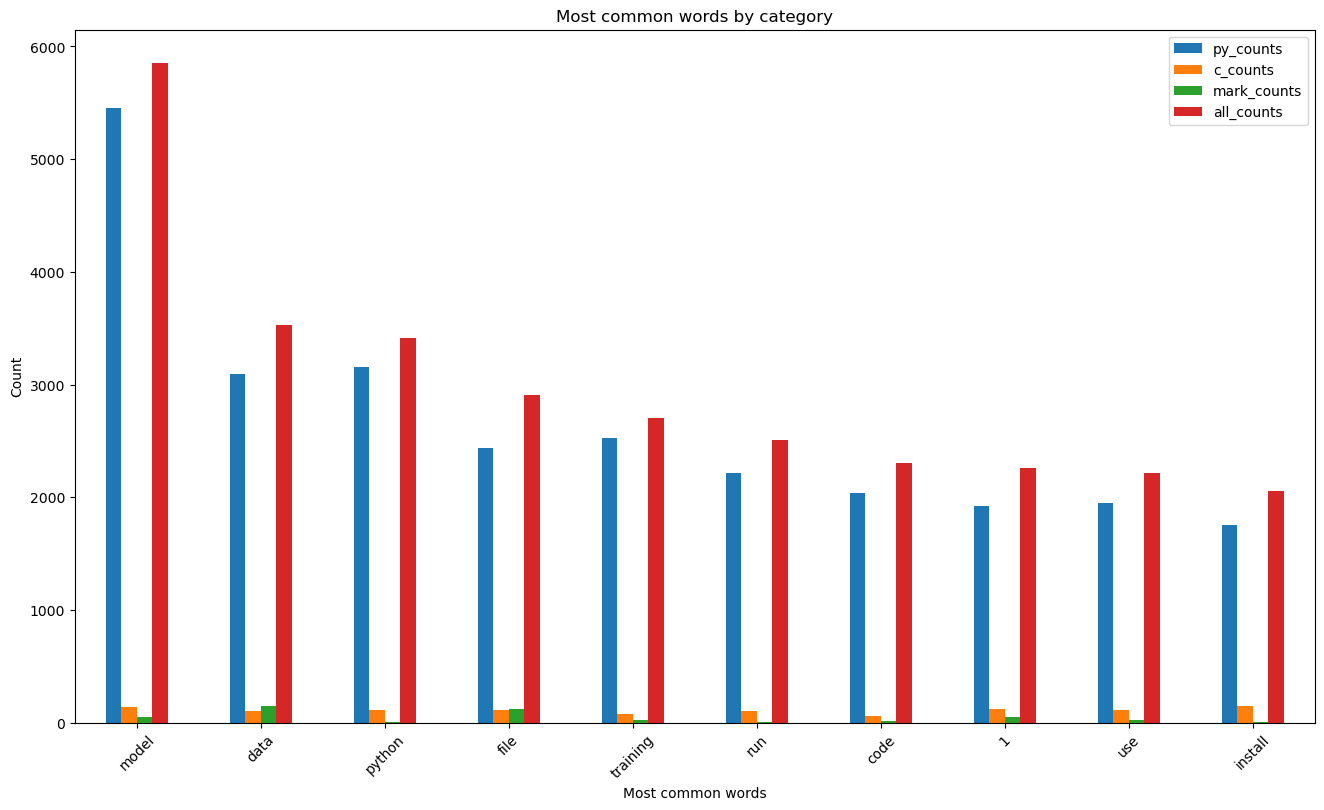

In [22]:
#Plot the most frequent words and color by label
word_counts.sort_values('all_counts', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

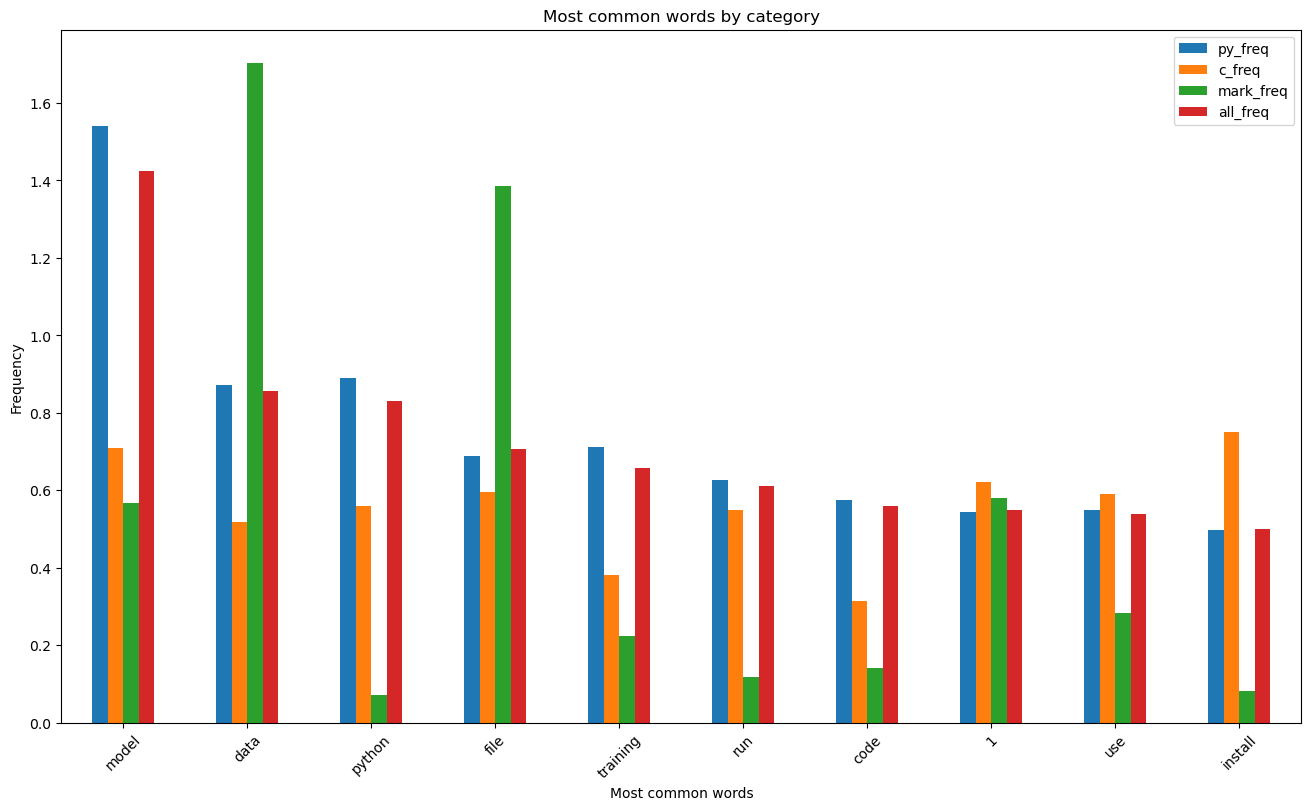

In [23]:
#Plot the most frequent words and color by label
word_freq.sort_values('all_freq', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Frequency')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Create dataframe with the word counts and frequencies for each language
words = pd.concat([word_counts, word_freq], axis=1)

In [25]:
# Look at the highest percent python words
words.sort_values('py_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,all_counts,py_freq,c_freq,mark_freq,all_freq
model,5455,138,48,5856,1.540299,0.709475,0.568115,1.425112
python,3154,109,6,3409,0.890578,0.560382,0.071014,0.829612
data,3092,101,144,3524,0.873071,0.519254,1.704344,0.857598
training,2523,74,19,2700,0.712406,0.380443,0.224879,0.657070
file,2436,116,117,2906,0.687840,0.596370,1.384779,0.707202
run,2217,107,10,2507,0.626002,0.550100,0.118357,0.610102
code,2040,61,12,2300,0.576024,0.313609,0.142029,0.559726
use,1949,115,24,2218,0.550329,0.591229,0.284057,0.539771
1,1926,121,49,2261,0.543834,0.622076,0.579950,0.550235
dataset,1762,49,122,2000,0.497526,0.251915,1.443958,0.486719


In [26]:
# Look at the highest percent c words
words.sort_values('c_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,all_counts,py_freq,c_freq,mark_freq,all_freq
install,1758,146,7,2058,0.496397,0.750604,0.082850,0.500834
build,225,141,4,477,0.063532,0.724898,0.047343,0.116082
model,5455,138,48,5856,1.540299,0.709475,0.568115,1.425112
example,1384,138,10,1657,0.390793,0.709475,0.118357,0.403246
1,1926,121,49,2261,0.543834,0.622076,0.579950,0.550235
file,2436,116,117,2906,0.687840,0.596370,1.384779,0.707202
use,1949,115,24,2218,0.550329,0.591229,0.284057,0.539771
python,3154,109,6,3409,0.890578,0.560382,0.071014,0.829612
run,2217,107,10,2507,0.626002,0.550100,0.118357,0.610102
data,3092,101,144,3524,0.873071,0.519254,1.704344,0.857598


In [27]:
# Look at the highest percent markdown words
words.sort_values('mark_freq', ascending=False).head(10)

,py_counts,c_counts,mark_counts,all_counts,py_freq,c_freq,mark_freq,all_freq
data,3092,101,144,3524,0.873071,0.519254,1.704344,0.857598
dataset,1762,49,122,2000,0.497526,0.251915,1.443958,0.486719
file,2436,116,117,2906,0.687840,0.596370,1.384779,0.707202
contains,539,30,83,733,0.152195,0.154234,0.982365,0.178382
participant,22,0,74,100,0.006212,0.000000,0.875843,0.024336
directory,660,24,65,802,0.186361,0.123387,0.769322,0.195174
session,33,0,50,85,0.009318,0.000000,0.591786,0.020686
1,1926,121,49,2261,0.543834,0.622076,0.579950,0.550235
model,5455,138,48,5856,1.540299,0.709475,0.568115,1.425112
audio,267,11,47,351,0.075391,0.056552,0.556279,0.085419


## N-Grams
### Bigrams

In [ ]:
# Bigrams!
all_bigrams = (pd.Series(nltk.ngrams(all_words.split(), 2)))
py_bigrams = (pd.Series(nltk.ngrams(py_words.split(), 2)))
c_bigrams = (pd.Series(nltk.ngrams(c_words.split(), 2)))
mark_bigrams = (pd.Series(nltk.ngrams(mark_words.split(), 2)))
other_bigrams = (pd.Series(nltk.ngrams(other_words.split(), 2)))

# Top 20 most common bigrams
top_20_all_bigrams = all_bigrams.value_counts().head(20)
top_20_py_bigrams = py_bigrams.value_counts().head(20)
top_20_c_bigrams = c_bigrams.value_counts().head(20)
top_20_mark_bigrams = mark_bigrams.value_counts().head(20)
top_20_other_bigrams = other_bigrams.value_counts().head(20)

# Get bigram counts for each language
al_bigram_counts = all_bigrams.value_counts()
py_bigram_counts = py_bigrams.value_counts()
c_bigram_counts = c_bigrams.value_counts()
mark_bigram_counts = mark_bigrams.value_counts()
other_bigram_counts = other_bigrams.value_counts()

# Get bigram frequencies for each language
al_bigram_freq = all_bigrams.value_counts(normalize=True)*100
py_bigram_freq = py_bigrams.value_counts(normalize=True)*100
c_bigram_freq = c_bigrams.value_counts(normalize=True)*100
mark_bigram_freq = mark_bigrams.value_counts(normalize=True)*100
other_bigram_freq = other_bigrams.value_counts(normalize=True)*100

# Combine bigram counts into one dataframe
bigram_counts = pd.concat([al_bigram_counts, py_bigram_counts, c_bigram_counts, mark_bigram_counts, other_bigram_counts], axis=1).fillna(0).astype(int)
bigram_counts.columns = ['all_bigram_count', 'py_bigram_count', 'c_bigram_count', 'mark_bigram_count', 'other_bigram_count']

# Combine bigram frequencies into one dataframe
bigram_freq = pd.concat([al_bigram_freq, py_bigram_freq, c_bigram_freq, mark_bigram_freq, other_bigram_freq], axis=1).fillna(0)
bigram_freq.columns = ['all_bigram_freq', 'py_bigram_freq', 'c_bigram_freq', 'mark_bigram_freq', 'other_bigram_freq']

# Combine bigram count and frequency dataframes
bigrams = pd.concat([bigram_counts, bigram_freq], axis=1)
bigrams.head()

### Trigrams

In [ ]:
# Trigrams!
all_trigrams = (pd.Series(nltk.ngrams(all_words.split(), 3)))
py_trigrams = (pd.Series(nltk.ngrams(py_words.split(), 3)))
c_trigrams = (pd.Series(nltk.ngrams(c_words.split(), 3)))
mark_trigrams = (pd.Series(nltk.ngrams(mark_words.split(), 3)))
other_trigrams = (pd.Series(nltk.ngrams(other_words.split(), 3)))

# Top 20 most common trigrams
top_20_all_trigrams = all_trigrams.value_counts().head(20)
top_20_py_trigrams = py_trigrams.value_counts().head(20)
top_20_c_trigrams = c_trigrams.value_counts().head(20)
top_20_mark_trigrams = mark_trigrams.value_counts().head(20)
top_20_other_trigrams = other_trigrams.value_counts().head(20)

# Get trigram counts for each language
al_trigram_counts = all_trigrams.value_counts()
py_trigram_counts = py_trigrams.value_counts()
c_trigram_counts = c_trigrams.value_counts()
mark_trigram_counts = mark_trigrams.value_counts()
other_trigram_counts = other_trigrams.value_counts()

# Get trigram frequencies for each language
al_trigram_freq = all_trigrams.value_counts(normalize=True)*100
py_trigram_freq = py_trigrams.value_counts(normalize=True)*100
c_trigram_freq = c_trigrams.value_counts(normalize=True)*100
mark_trigram_freq = mark_trigrams.value_counts(normalize=True)*100
other_trigram_freq = other_trigrams.value_counts(normalize=True)*100

# Combine trigram counts into one dataframe
trigram_counts = pd.concat([al_trigram_counts, py_trigram_counts, c_trigram_counts, mark_trigram_counts, other_trigram_counts], axis=1).fillna(0).astype(int)
trigram_counts.columns = ['all_trigram_count', 'py_trigram_count', 'c_trigram_count', 'mark_trigram_count', 'other_trigram_count']

# Combine trigram frequencies into one dataframe
trigram_freq = pd.concat([al_trigram_freq, py_trigram_freq, c_trigram_freq, mark_trigram_freq, other_trigram_freq], axis=1).fillna(0)
trigram_freq.columns = ['all_trigram_freq', 'py_trigram_freq', 'c_trigram_freq', 'mark_trigram_freq', 'other_trigram_freq']

# Combine trigram count and frequency dataframes
trigrams = pd.concat([trigram_counts, trigram_freq], axis=1)
trigrams.head()

<Axes: >

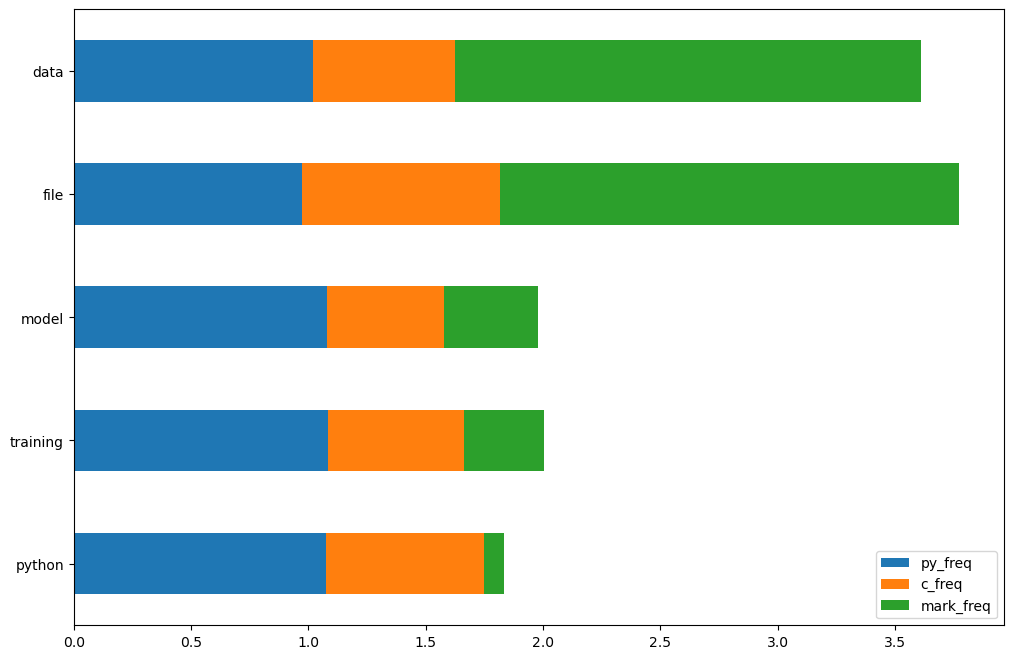

In [34]:
# Visualize language bigrams as percent of all word counts
(word_freq.sort_values(by='all_freq', ascending=False)
    .head()
    .apply(lambda row: row / row['all_freq'], axis=1)
    .drop(columns=['all_freq'])
    .sort_values(by='mark_freq')
    .plot.barh(stacked=True, figsize=(12, 8)))

In [35]:
# Trigrams!
all_trigrams = (pd.Series(nltk.ngrams(all_words.split(), 3)))
py_trigrams = (pd.Series(nltk.ngrams(py_words.split(), 3)))
c_trigrams = (pd.Series(nltk.ngrams(c_words.split(), 3)))
mark_trigrams = (pd.Series(nltk.ngrams(mark_words.split(), 3)))

# Top 20 most common trigrams
top_20_all_trigrams = all_trigrams.value_counts().head(20)
top_20_py_trigrams = py_trigrams.value_counts().head(20)
top_20_c_trigrams = c_trigrams.value_counts().head(20)
top_20_mark_trigrams = mark_trigrams.value_counts().head(20)

#### Looking at **most** frequent *bigram* of Python:

### 2. Is `('arxivorg', 'ab')` statistically significant to Python compared to *All* other languages
- $H_0$: There is no relationship between `('arxivorg', 'ab')` and Python
- $H_a$: There is a relationship between `('arxivorg', 'ab')` and Python

#### Steps:
- 1a. Create visualization that shows counts of all languages most frequent bigrams


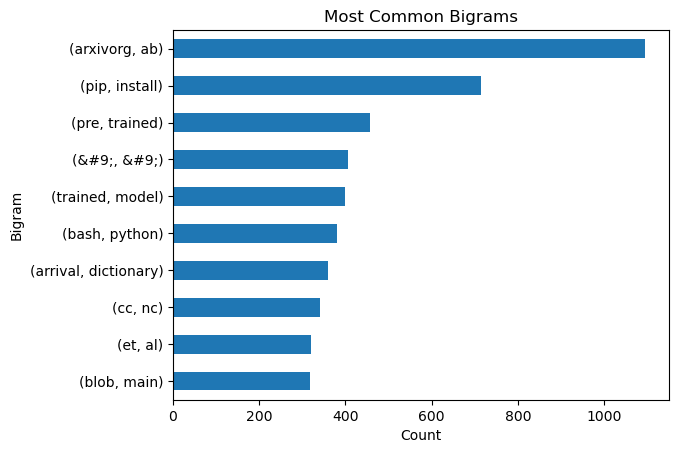

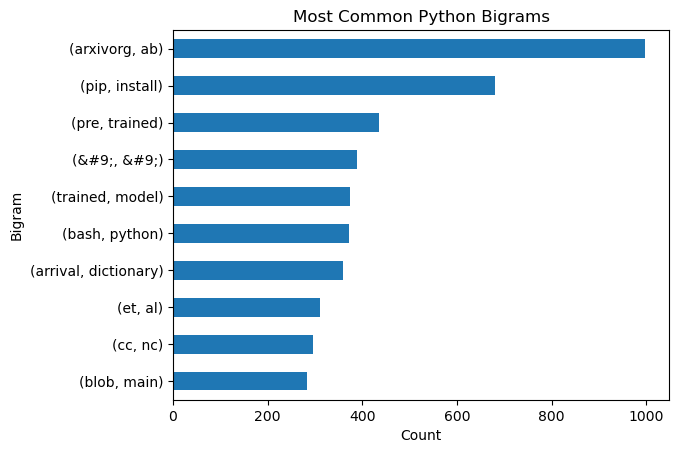

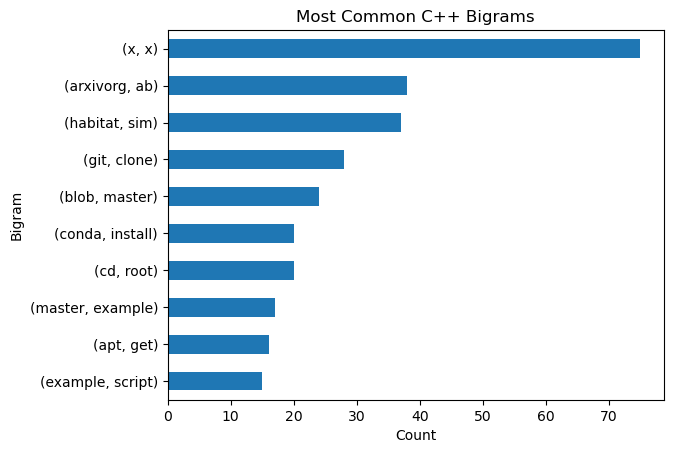

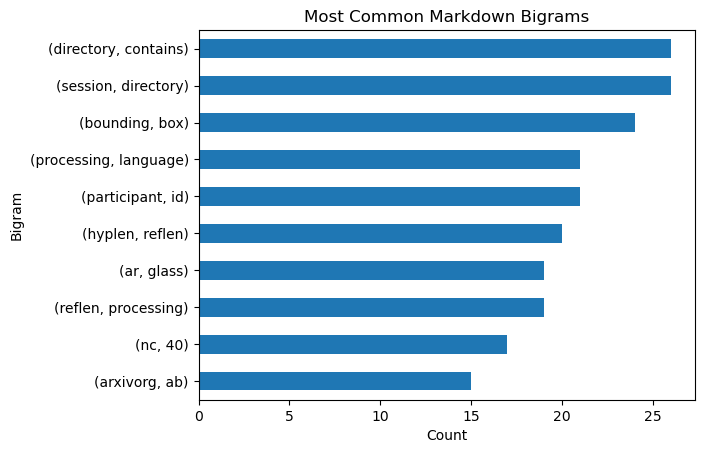

In [44]:
top_20_all_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Bigrams')
plt.show()

top_20_py_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Python Bigrams')
plt.show()

top_20_c_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common C++ Bigrams')
plt.show()

top_20_mark_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Markdown Bigrams')
plt.show()

top_20_other_bigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Other Bigrams')
plt.show()

## Question 2 Answer:
    We can see the bigram (arxivorg,ab) values shows up in 'python' ~1000 times and about ~1100 in all words

    Although only visually confirming -- we will assume that this bigram has some sort of relationship to Python.

#### Looking at **most** frequent *trigram* of Python:

### 3. Is `('pre','trained','model')` statistically significant to Python compared to *All* other languages
- $H_0$: There is no relationship between `('pre','trained','model')` and Python
- $H_a$: There is a relationship between `('pre','trained','model')` and Python

#### Steps:
- 1a. Engineer column that counts `('pre','trained','model')` within every value

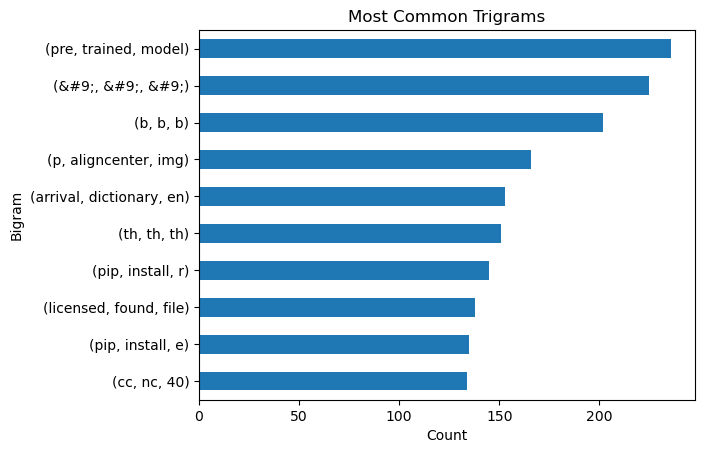

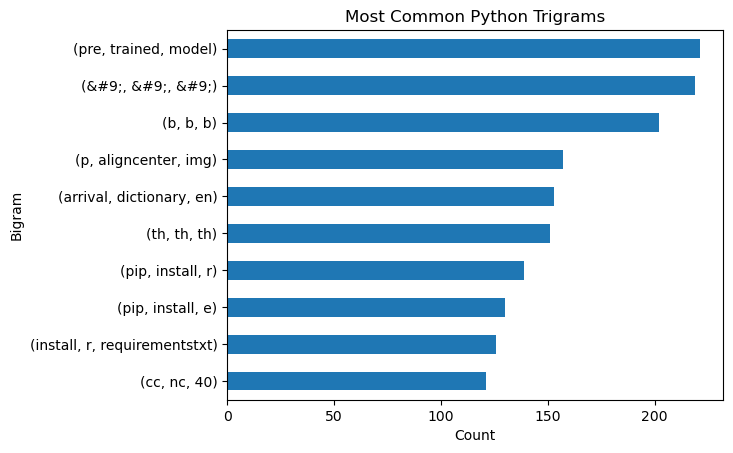

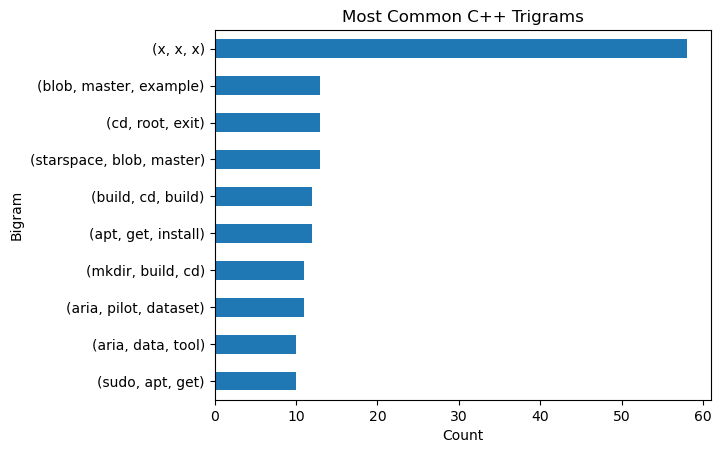

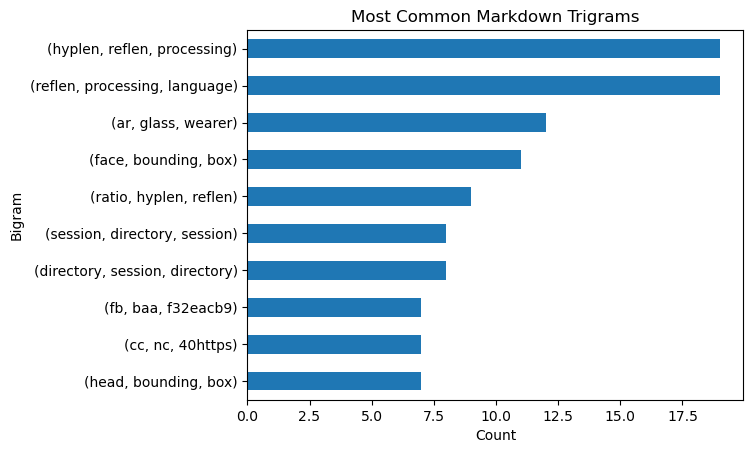

NameError: name 'top_20_other_trigrams' is not defined

In [54]:
top_20_all_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Trigrams')
plt.show()

top_20_py_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Python Trigrams')
plt.show()

top_20_c_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common C++ Trigrams')
plt.show()

top_20_mark_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Markdown Trigrams')
plt.show()

top_20_other_trigrams.head(10).plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most Common Other Trigrams')
plt.show()

## Modeling

### Baseline:

Baseline Prediction - Python \
Baseline Accuracy - 82.57%

### Model 1: Logistic Regression

In [3]:
train, test = train_test_split(df, train_size=.6, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

# Define your specific list of n-grams as a vocabulary
specific_ngrams = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=1000).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

NameError: name 'train_test_split' is not defined

### Model 2: Decision Tree Classifier (Specified Features)

Features = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']

In [ ]:
# Split the data into training and test sets
train, test = train_test_split(df, train_size=0.7, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

# Define your specific list of unigrams, bigrams, and trigrams as a vocabulary
specific_ngrams = ['python', 'example', 'dataset', 'run', 'arrival dictionary', 'x x', 'session directory', '10000 10000', 'ar glass wearer']

tfidf = TfidfVectorizer(vocabulary=specific_ngrams)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Create and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=666, max_depth=2)
dt.fit(X_train, y_train)

# Make predictions on the training and test data
train_predicted = dt.predict(X_train)
test_predicted = dt.predict(X_test)

# Evaluate the Decision Tree classifier
print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, train_predicted)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, test_predicted)))
print('---')
print('Confusion Matrix')
print(confusion_matrix(y_test, test_predicted))
print('---')
print(classification_report(y_test, test_predicted))

### Model 3: Decision Tree Classifier 

In [ ]:
# Split the data into training and test sets
train, test = train_test_split(df, train_size=0.7, random_state=666)

X_train = train.lematized
X_test = test.lematized

y_train = train.language
y_test = test.language

tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Create and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=666, max_depth=2)
dt.fit(X_train, y_train)

# Make predictions on the training and test data
train_predicted = dt.predict(X_train)
test_predicted = dt.predict(X_test)

# Evaluate the Decision Tree classifier
print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, train_predicted)))
print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, test_predicted)))
print('---')
print('Confusion Matrix')
print(confusion_matrix(y_test, test_predicted))
print('---')
print(classification_report(y_test, test_predicted))

<hr style="border:2px solid black">

# **Conclusions**


### <u>Modeling:</u>

>**<u>The final model only outperformed baseline by 2%. Possible reason:</u>**
>* Dataset was imbalanced toward Python. Decision Tree Model without specifiying ngram features performed the best.

### <u>Recommendations:</u>
>* Use Model to Analyze Github repositories of job applicants to see if they have the requisite skills for the MetaResearch team. 

### <u>Next Steps:</u>
>* Obtain more data for languages other than Python.